# Definitions:

## Import

In [139]:
import pandas as pd
import numpy as np
import os

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier



print('Importing all done!')

Importing all done!


## Define Functions

### automatic_feature_extraction

In [140]:
def automatic_feature_extraction(dataset,filepath):
     # Not tested, last time took 1 hour 15 minutes and didnt feel like sittinng through that again. Result is in dataset
        
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Data Cleaning
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName']
    data['5IAL_3_301.BatchName']= data['5IAL_3_301.BatchName'].fillna('No Batch Specified')
    
    
    # Filter out everything that is not a batch
    column_name = '5IAL_3_301.BatchName'
    mask = (data[column_name].str.len() >= 11) & (data[column_name].str.len() <= 12)
    data_selected = data[mask]
    
    Batch_Names=data['5IAL_3_301.BatchName'][mask]
    unique_names=pd.DataFrame(Batch_Names.unique(),columns=['5IAL_3_301.BatchName'])
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Create Target
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName'][mask] #gets all batches
    search_strings = ['MD112304504', 'CP7012217502'] # [ 14-02-23:'MD112304504', 06-10-22:'MD112227901', 27-06-22'CP7012217502'] -MD112227901
    
    y=unique_names.copy()
    
    y['contains_search_string'] = False
    
    
    #check for name wether its in range of one of the search strin names, if so label as True.
    for i in range(len(y)):
        for j in range(i+1, min(i+21, len(y))):
            if any([search_str == y.loc[j, '5IAL_3_301.BatchName'] for search_str in search_strings]):
                y.loc[i, 'contains_search_string'] = True
                break

    print(np.sum(y['contains_search_string']))
    
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Automatic Feature extraction with tsfresh
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    import tsfresh
    from tsfresh import extract_features
    from tsfresh import select_features
    from tsfresh.utilities.dataframe_functions import impute

    data_selected=data_selected.drop(['5IAL_3_XPV301.36'],axis=1)

    extracted_features = extract_features(data_selected, column_id="5IAL_3_301.BatchName")

    impute(extracted_features)

    y=y.set_index("5IAL_3_301.BatchName")

    features_filtered = select_features(extracted_features, y['contains_search_string'])
    features_filtered.to_csv(filepath)
    
    print('Features saved as csv file to {}'.format(filepath))

    
    return features_filterd

### clean_data

In [141]:
def Clean_data(data, use_PCA):
    
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Data Cleaning
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName']
    data['5IAL_3_301.BatchName']= data['5IAL_3_301.BatchName'].fillna('No Batch Specified')
    
    
    # Filter out everything that is not a batch
    column_name = '5IAL_3_301.BatchName'
    mask = (data[column_name].str.len() >= 11) & (data[column_name].str.len() <= 12)
    data_selected = data[mask]
    data=data_selected

    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Normalise All data
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    Normalise using the z-score
    """
    print(data)


    BatchName=data['5IAL_3_301.BatchName']
    Dates=data['Date']

 
    data.drop(['5IAL_3_301.BatchName','Date'],axis=1,inplace=True)

    data_norm=pd.DataFrame()
    data_norm_values=pd.DataFrame()
    for col in data:
        zval=(data[col]-np.mean(data[col]))/np.std(data[col])
        data_norm=pd.concat([data_norm,zval],axis=1)
        data_norm_values[col]=[np.mean(data[col]),np.std(data[col])]

    data_norm_values=data_norm_values.rename(index={0:'mean', 1:'std'})
    
    #data_norm_values.to_csv('/kaggle/working/normalisation_values.csv')
        
    data_norm['5IAL_3_301.BatchName']=BatchName
    data['5IAL_3_301.BatchName']=BatchName
    
    
    """ 
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Feature Creation
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    data_norm['frac']=data_norm['5IAL_3_P301.70']/data_norm['5IAL_3_FIT301.61MF']
    
    mean_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).mean()
    mean_grouped=mean_grouped.add_suffix('_mean')
    
    std_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).std()
    std_grouped=std_grouped.add_suffix('_std')

    max_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).max()
    max_grouped=max_grouped.add_suffix('_max')

    min_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).min()
    min_grouped=min_grouped.add_suffix('_min')

    var_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).var()
    var_grouped=var_grouped.add_suffix('_var')

    sum_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).sum()
    sum_grouped=sum_grouped.add_suffix('_sum')
        


    
    Batch_duration=data.groupby(data['5IAL_3_301.BatchName']).size()
    Batch_duration=pd.DataFrame(Batch_duration, columns=['Batch_duration'])
    
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    One-hot Encoder
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName'][mask]
    unique_names=pd.DataFrame(Batch_Names.unique(),columns=['5IAL_3_301.BatchName'])

    batch_types_list=[]
    
    # for every unique name, check length and choose wether to take the first 3 or 4 letters
    for i in range(len(unique_names)):
        if len(unique_names.loc[i][0]) == 11:
            substring=unique_names.loc[i][0][0:3]
        else:
            substring=unique_names.loc[i][0][0:4]
        batch_types_list.append(substring.upper())

    series=pd.Series(batch_types_list)
    series= series.replace({'IU7':'IU70'})
    series_unique=series.unique()
    
    One_hot=pd.get_dummies(series)

    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Create Target
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName'][mask] #gets all batches
    search_strings = ['MD112304504', 'CP7012217502'] # ['MD112304504','MD112227901', 'CP7012217502'] -MD112227901
    
    y=unique_names.copy()
    
    y['contains_search_string'] = False
    
    
    #check for name wether its in range of one of the search strin names, if so label as True.
    for i in range(len(y)):
        for j in range(i+1, min(i+21, len(y))):
            if any([search_str == y.loc[j, '5IAL_3_301.BatchName'] for search_str in search_strings]):
                y.loc[i, 'contains_search_string'] = True
                break

    print(np.sum(y['contains_search_string']))
    
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Create X and y
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """ 
    Eind=pd.merge(pd.merge(mean_grouped,std_grouped,on=['5IAL_3_301.BatchName']), unique_names, on=['5IAL_3_301.BatchName'])

    # Add in Batch duration
    Eind=pd.merge(Eind,Batch_duration,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,max_grouped,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,min_grouped,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,var_grouped,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,sum_grouped,on=['5IAL_3_301.BatchName'])

    Eind=pd.merge(Eind,Batch_duration,on=['5IAL_3_301.BatchName'])
    
    X_t = Eind.drop(['5IAL_3_301.BatchName'],axis=1)
    X_t=X_t.fillna(0)
    
    
    y = y['contains_search_string']
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    PCA
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """ 
    from sklearn.decomposition import PCA
    
    pca = PCA()
    X_pca = pca.fit_transform(X_t)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    
    
    # the use_PCA setting
    if use_PCA == True:
        X=pd.concat([X_pca,One_hot],axis=1)
    else:
        X=pd.concat([X_t,One_hot],axis=1)

    return X,y

### devide

In [142]:
def devide(x,y):
    if ((x == 0) | (y == 0)):
        return 0
    else: 
        return x/y

### Confuion

In [143]:
def Confusion(y_real,y_pred,silent):
    from sklearn import metrics 
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    cf=confusion_matrix(y_real,y_pred)
    TN=cf[0][0]
    TP=cf[1][1]
    FP=cf[0][1]
    FN=cf[1][0]

    Recall=devide(TP,(TP+FN))
    Precision=devide(TP,(TP+FP))
    F1=2*devide((Recall*Precision),(Precision+Recall))
    
    
    
    if silent != 1:
        print(F1)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = [False, True])
        cm_display.plot()
        plt.show()

    return(F1)

### Train_fit_Validate_model

In [144]:
def Train_fit_Validate_model(X_train,y_train,X_test,y_test,model,plot):
    model = model

    model.fit(X_train,y_train)


    y_fit=model.predict(X_train)
    y_pred=model.predict(X_test)

    if plot == 1:
        print('Test Results:')
        F1=Confusion(y_test,y_pred,silent=0)

        print(' ')
        print('Train results:')
        Confusion(y_train,y_fit,silent=0)
        
    elif plot == 0:
        F1=Confusion(y_test,y_pred,silent=1)

    return F1

### train_and_test_kfold

In [145]:
def train_and_test_kfold(X,y,model,n_splits,plot):

    import numpy as np
    from sklearn.model_selection import StratifiedKFold
    from imblearn.over_sampling import SMOTE
    
    F1_array=[]

    kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
    for train,test in kf.split(X,y):
        X_train=X.loc[train]
        y_train=y.loc[train]

        X_test=X.loc[test]
        y_test=y.loc[test]

        oversample = SMOTE()
        X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)


        F1=Train_fit_Validate_model(X_train_o,y_train_o,X_test,y_test, model=model, plot=plot)
        F1_array.append(F1)
    
    return F1_array

# Real Work

In [146]:
current_path=os.getcwd()
data=pd.read_csv(current_path+'\\train_data.bz2',parse_dates=[0],compression='bz2')
data.rename(columns={'0':'Date'},inplace=True)

features=pd.read_csv(current_path+'\\feature_extraction.csv')
features.rename(columns={'Unnamed: 0':'5IAL_3_301.BatchName'},inplace=True)
#features.head()

C:\Users\klabbf\AppData\Local\Temp\ipykernel_11676\1044564187.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(current_path+'\\train_data.bz2',parse_dates=[0],compression='bz2')


In [147]:
import tsfresh

features_edit=features.set_index('5IAL_3_301.BatchName')

kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(features_edit)
print(kind_to_fc_parameters)

{'5IAL_3_WY301.54': {'absolute_maximum': None, 'maximum': None, 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'quantile': [{'q': 0.9}, {'q': 0.8}]}, '5IAL_3_TT301.50': {'fft_coefficient': [{'attr': 'angle', 'coeff': 0}, {'attr': 'real', 'coeff': 1}], 'index_mass_quantile': [{'q': 0.1}, {'q': 0.2}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 4}, {'num_segments': 10, 'segment_focus': 3}], 'variation_coefficient': None, 'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.2, 'ql': 0.0}], 'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'}], 'linear_trend': [{'attr': 'rvalue'}, {'attr': 'slope'}], 'ar_coefficient': [{'coeff': 0, 'k':

## Prepare X and y

In [148]:
X,y = Clean_data(data, False)

X=pd.concat([X,features.drop(['5IAL_3_301.BatchName'],axis=1)],axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=True) #split data into validation and train+test

oversample = SMOTE()
X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)

print(y_train_o.value_counts())

                      Date  5IAL_3_TT301.50  5IAL_3_QIT301.52  \
1169   2022-04-11 07:29:00            21.75             10.07   
1170   2022-04-11 07:30:00            25.87             10.07   
1171   2022-04-11 07:31:00            25.81              9.90   
1172   2022-04-11 07:32:00            26.21              9.92   
1173   2022-04-11 07:33:00            26.84             10.09   
...                    ...              ...               ...   
475255                 NaT            23.48              9.26   
475256                 NaT            23.44              9.26   
475257                 NaT            23.40              9.27   
475258                 NaT            23.37              9.27   
475259                 NaT            23.34              9.26   

        5IAL_3_PIT 301.55  5IAL_3_QIT301.57  5IAL_3_PIT301.60  \
1169                -0.02              0.00              0.00   
1170                -0.02              0.00              0.01   
1171                 1.0

C:\Users\klabbf\AppData\Local\Temp\ipykernel_11676\736068581.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['5IAL_3_301.BatchName','Date'],axis=1,inplace=True)
C:\Users\klabbf\AppData\Local\Temp\ipykernel_11676\736068581.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['5IAL_3_301.BatchName']=BatchName


40
False    869
True     869
Name: contains_search_string, dtype: int64


In [149]:
print(X.columns)

Index(['5IAL_3_TT301.50_mean', '5IAL_3_QIT301.52_mean',
       '5IAL_3_PIT 301.55_mean', '5IAL_3_QIT301.57_mean',
       '5IAL_3_PIT301.60_mean', '5IAL_3_FIT301.61MF_mean',
       '5IAL_3_FIT301.61VF_mean', '5IAL_3_FIT301.61D_mean',
       '5IAL_3_PIT301.63_mean', '5IAL_3_P301.70_mean',
       ...
       '5IAL_3_TT301.50__number_crossing_m__m_1',
       '5IAL_3_PIT301.63__abs_energy',
       '5IAL_3_PIT301.63__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)',
       '5IAL_3_QIT301.52__c3__lag_1',
       '5IAL_3_TT301.50__fft_coefficient__attr_"real"__coeff_1',
       '5IAL_3_FIT301.61D__quantile__q_0.6',
       'frac__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)',
       '5IAL_3_PIT301.63__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)',
       '5IAL_3_TT301.50__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       '5IAL_3_TT301.50__linear_trend__attr_"slope"'],
      dtype='object', length=367)


# Neural Network

Test Results:
0.47619047619047616


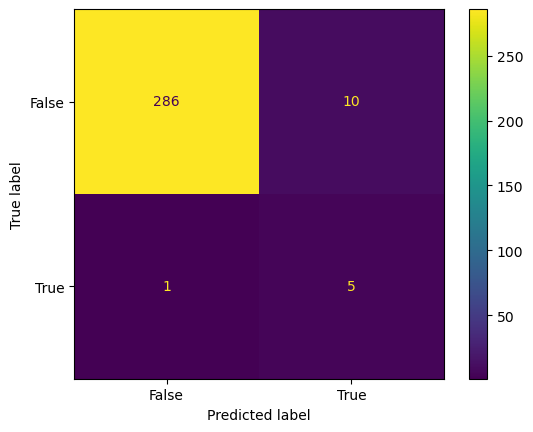

 
Train results:
1.0


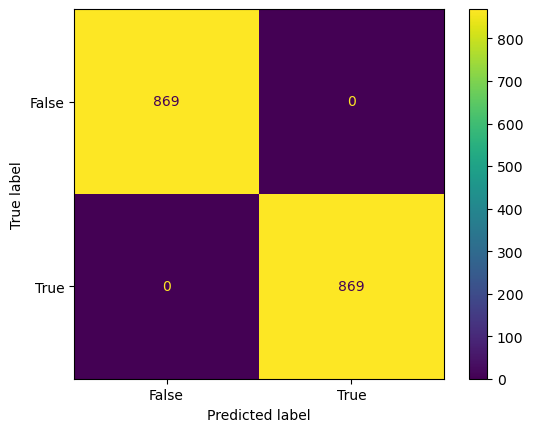

0.47619047619047616

In [150]:
from sklearn.neural_network import MLPClassifier #(https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Train_fit_Validate_model(X_train_o,y_train_o,X_test,y_test,MLPClassifier(max_iter=1000),plot=True)

# Random Forest Classifier

Test Results:
0.7692307692307692


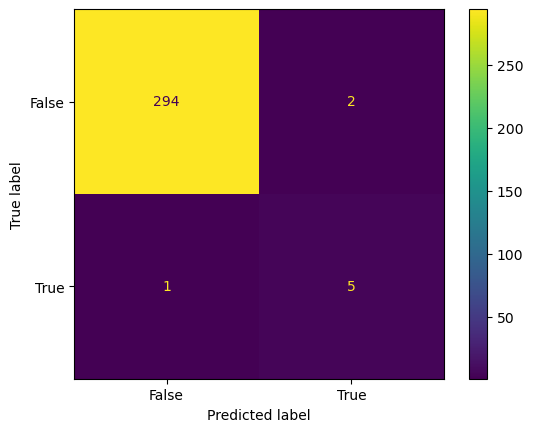

 
Train results:
1.0


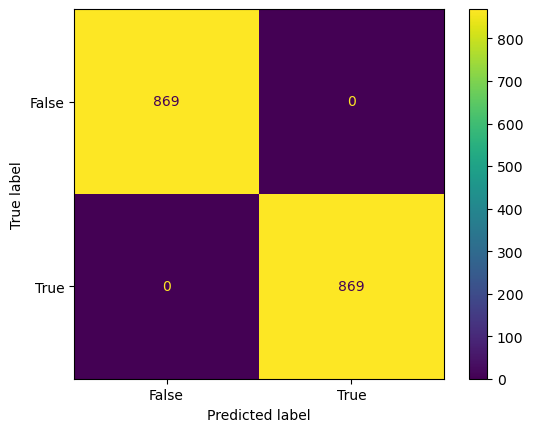

0.7692307692307692

In [151]:
from sklearn.ensemble import RandomForestClassifier

Train_fit_Validate_model(X_train_o,y_train_o,X_test,y_test,RandomForestClassifier(),plot=True)

# XGBoost

Test Results:
0.6153846153846153


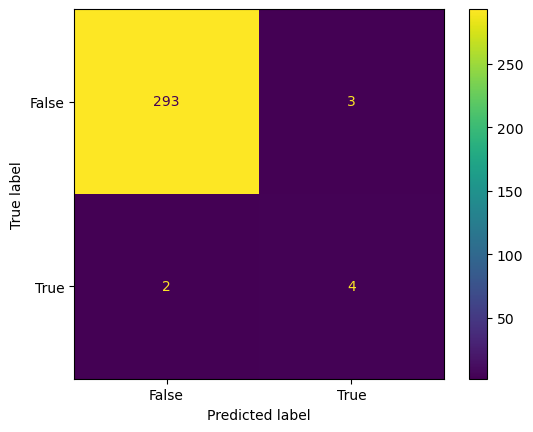

 
Train results:
1.0


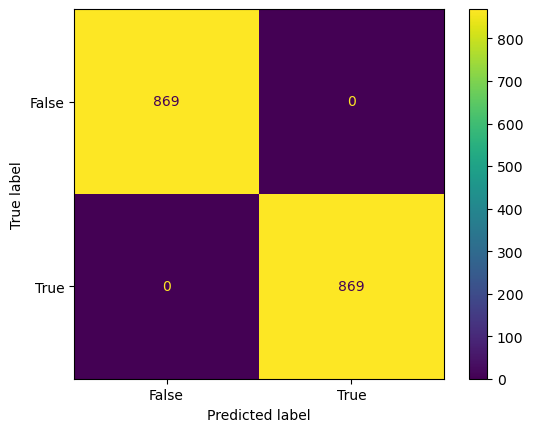

0.6153846153846153


In [152]:
import xgboost as xgb

model_xgb=xgb.XGBClassifier()

F1=Train_fit_Validate_model(X_train_o,y_train_o,X_test,y_test, model=model_xgb, plot=1)

print(F1)

Test Results:
0.7826086956521738


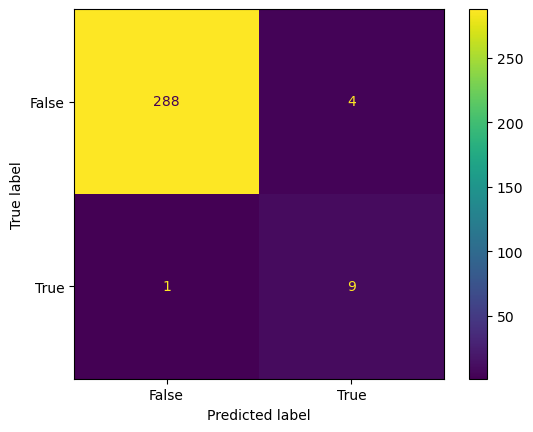

 
Train results:
1.0


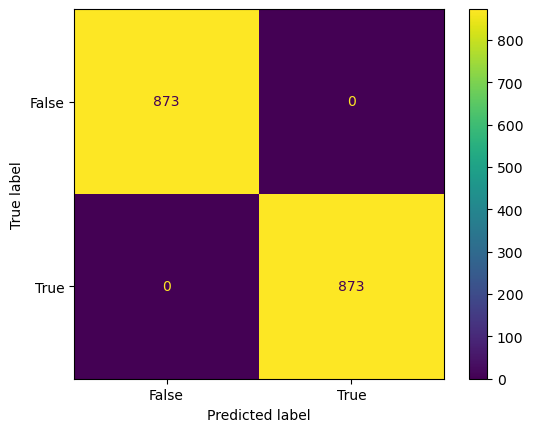

Test Results:
0.7777777777777777


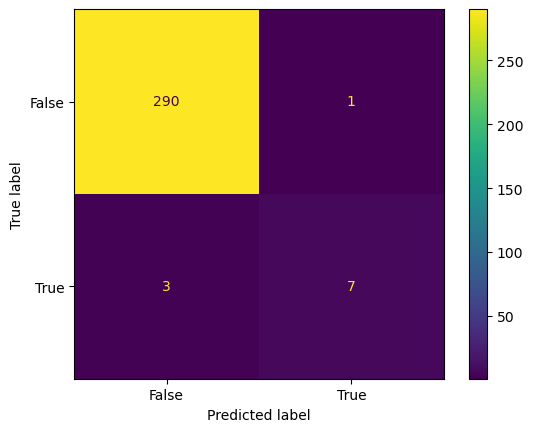

 
Train results:
1.0


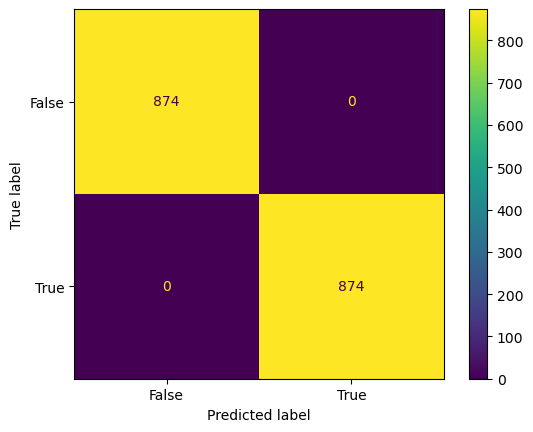

Test Results:
0.8000000000000002


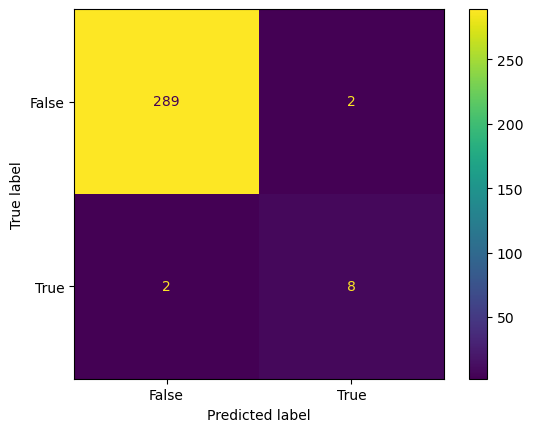

 
Train results:
1.0


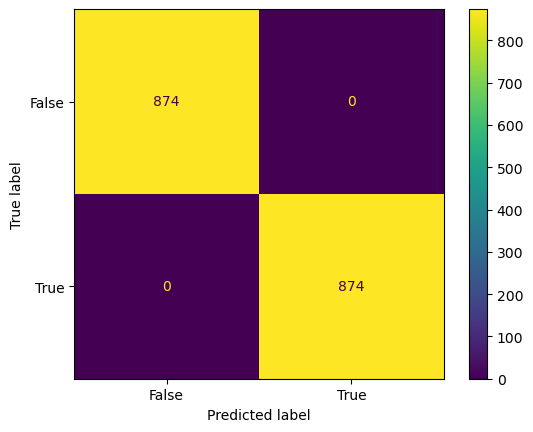

Test Results:
0.7777777777777777


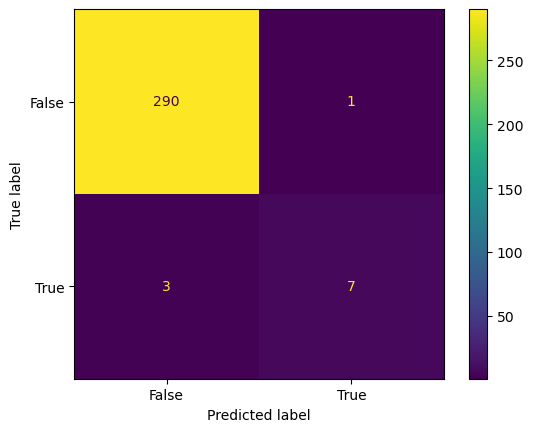

 
Train results:
1.0


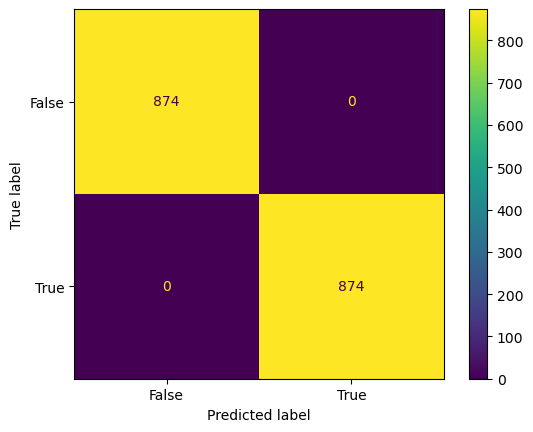

0.7845410628019324


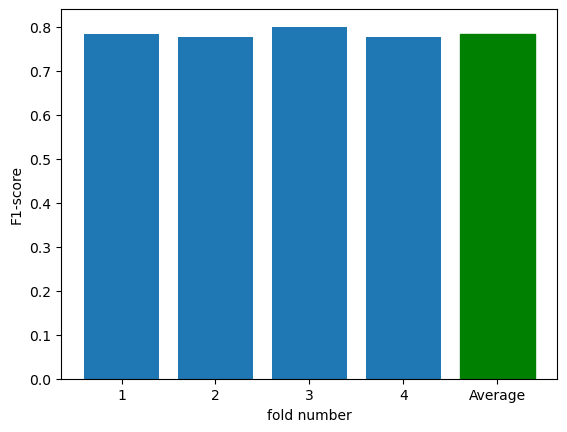

In [153]:
import xgboost as xgb

model=xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.075, max_depth= 3, n_estimators= 500)

Test_peformance= train_and_test_kfold(X,y,model=model,n_splits=4,plot=1)

print(np.mean(Test_peformance))

import matplotlib.pyplot as plt

plot=Test_peformance.copy()
plot.append(np.mean(plot))

bar=plt.bar(['1','2','3','4','Average'],plot)
plt.ylabel('F1-score')
plt.xlabel('fold number')
bar[4].set_color('g')

In [154]:
import xgboost as xgb

lst=[]
for i in range(30):
    Test_peformance= train_and_test_kfold(X,y,model=xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.075, max_depth= 3, n_estimators= 500),n_splits=4,plot=0)
    lst.append(Test_peformance)

print(np.mean(lst))
print(np.std(lst))


In [ ]:
another_list_mean=[]
another_list_std=[]
for sub_lst in lst:
    another_list_mean.append(np.mean(sub_lst))
    another_list_std.append(np.std(sub_lst))

plot=another_list_mean.copy()
plot.append(np.mean(another_list_mean))

err=another_list_std.copy()
err.append(np.std(lst))

fig, ax = plt.subplots(figsize=(20,10))

colors = ['#1f77b4'] * 31
colors[30] = 'green'

ax.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','Average'],plot,yerr=err,capsize=10,color=colors)
ax.set_ylabel('F1-score',fontsize=20)
ax.set_xlabel('fold number',fontsize=20)
ax.tick_params(axis='both', labelsize=14)

params = { 'max_depth': [3,4,5,6,7,8,10,13],
           'learning_rate': [0.01, 0.05,0.075 ,0.1,0.15],
           'n_estimators': [100,300,500,700,1000],
           'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8]}
           
xgbr = xgb.XGBClassifier()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='f1')

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.075, 'max_depth': 3, 'n_estimators': 500}

In [ ]:
# from sklearn.model_selection import GridSearchCV

# X,y = Clean_data(data, False)

# X=pd.concat([X,features.drop(['5IAL_3_301.BatchName'],axis=1)],axis=1)

# params = { 'max_depth': [3,4,5,6,7,8,10,13],
#            'learning_rate': [0.01, 0.05,0.075 ,0.1,0.15],
#            'n_estimators': [100,300,500,700,1000],
#            'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8]}
# xgbr = xgb.XGBClassifier()
# clf = GridSearchCV(estimator=xgbr, 
#                    param_grid=params,
#                    scoring='f1')
# clf.fit(X, y)
# print("Best parameters:", clf.best_params_)

# Keras Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers



Dropout_rate=0.2

model_keras = Sequential(
    [
        Input(shape=(X_train.shape[1])),
        
        Dense(1200, activation='relu'),
        
        Dropout(rate=Dropout_rate),
        
        Dense(1000, activation='relu'),
        
        Dropout(rate=Dropout_rate),
        
        Dense(800, activation='relu'),
        
        Dropout(rate=Dropout_rate),
        
        Dense(600, activation='relu'),
        
        Dropout(rate=Dropout_rate),
        
        Dense(400, activation='relu'),
        
        Dropout(rate=Dropout_rate),
        
        Dense(200, activation='relu'),
        
        Dropout(rate=Dropout_rate),
        
        Dense(100, activation='relu'),
    
        Dense(1, activation='sigmoid')
    ])

model_keras.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['binary_accuracy'],)
model_keras.summary()

In [ ]:
model = model_keras

history=model.fit(
    X_train_o,
    y_train_o,
    epochs=3,
    validation_split=0.2
)


decision_boundary=0.9

y_train_pred=(model.predict(X_train)>decision_boundary).astype(int)
y_test_pred=(model.predict(X_test)> decision_boundary).astype(int)
y_pred=(model.predict(X)> decision_boundary).astype(int)

print('Test Results:')
Confusion(y_test,y_test_pred,silent=0)

print(' ')
print('Train results:')
Confusion(y_train,y_train_pred,silent=0)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_o, y_o = oversample.fit_resample(X, y)

model=xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.075, max_depth= 3, n_estimators= 500)
model.fit(X_o,y_o)

y_pred=model.predict(X)
print(np.sum(y_pred))

model.save_model('membrane_guess_model.json')